# Let’s Reproduce GPT-2 (124M)

## Andrej Karpathy GPT Course - Neural Networks: Zero to Hero

### Lesson 10 - Let's Reproduce GPT-2 (124M): Sections 3 and 4

+ YouTube video:
    + https://www.youtube.com/watch?v=l8pRSuU81PU

#####  Jun 9, 2024

##### Andrej's Video Comments
We reproduce the GPT-2 (124M) from scratch. This video covers the whole process: First we build the GPT-2 network, then we optimize its training to be really fast, then we set up the training run following the GPT-2 and GPT-3 paper and their hyperparameters, then we hit run, and come back the next morning to see our results, and enjoy some amusing model generations. Keep in mind that in some places this video builds on the knowledge from earlier videos in the Zero to Hero Playlist (see my channel). You could also see this video as building my nanoGPT repo, which by the end is about 90% similar.

+ Full course details: 
    + https://karpathy.ai/zero-to-hero.html
+ GitHub repository with all the changes in this video as individual commits (build-nanogpt)
    + https://github.com/karpathy/build-nanogpt
+ GitHub repository of GPT-2 based on the this "Let's Reproduce GPT-2" tutorial by user Lxrd-AJ
    + https://github.com/Lxrd-AJ/GPT2
+ nanoGPT repository
    + https://github.com/karpathy/nanoGPT
+ LLM.c Repository
    + https://github.com/karpathy/llm.c

### YouTube video contents: Sections 3 and 4

#### Section 3: Chapters
+ 02:14:55 - SECTION 3: hyperpamaters, AdamW, gradient clipping
+ 02:21:06 - learning rate scheduler: warmup + cosine decay
+ 02:26:21 - batch size schedule, weight decay, FusedAdamW, 90ms
+ 02:34:09 - gradient accumulation
+ 02:46:52 - distributed data parallel (DDP)
+ 03:10:21 - datasets used in GPT-2, GPT-3, FineWeb (EDU)
+ 03:23:10 - validation data split, validation loss, sampling revive
+ 03:28:23 - evaluation: HellaSwag, starting the run

#### Section 4: Chapters
+ 03:43:05 - SECTION 4: results in the morning! GPT-2, GPT-3 repro
+ 03:56:21 - shoutout to llm.c, equivalent but faster code in raw C/CUDA
+ 03:59:39 - summary, phew, build-nanogpt github repo

In [5]:
# GPT-2 VERSION THREE: OPTIMIZED MODEL TRAINED FROM RANDOMIZED WEIGHTS
# Version of: GPT2/train_gpt.py

import math
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import inspect


class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embed % config.n_head == 0
        # key, query, value projections for all heads but batched
        self.c_attn = nn.Linear(config.n_embed, 3 * config.n_embed)          # Project q,k,v in one step
        # output projection of the attention layer
        self.c_proj = nn.Linear(config.n_embed, config.n_embed)
        self.c_proj.NANOGPT_SCALE_INIT = 1                                   # Enable flag for this module
        # Regularization
        self.n_head = config.n_head
        self.n_embed = config.n_embed
        # not really a 'bias' - more of a mask. The name is chosen to match OpenAI/HF naming
        # buffers are equivalent to States in MATLAB's custom layers
        # `bias` is a (1, 1, T, T) tensor, useful for broadcasting
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                             .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()     # Batch size, sequence length, embedding dimensionality (e_embed)
        # Calculate query, key & values for all heads in batch and move head forward to be the batch
        # nh is "number of heads", hs is "head size", and C is "number of channels" (nh * hs)
        # In GPT-2 (124M), n_head=12, hs=64 so nh*hs = 768 channels in the transformer
        qkv = self.c_attn(x)   # computes query, key & value in parallel. Resulting tensor is (B,T,C) where C = 3 * n_embed
        q, k, v = qkv.split(self.n_embed, dim=2)         # Split the BxTx(3*C) matrix into (B,T,C) chunks where C = n_embed
        # Apply these multi-head operations efficiently in parallel batches
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, T, nh, hs) --> (B, nh, T, hs)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, T, nh, hs) --> (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, T, nh, hs) --> (B, nh, T, hs)
        # Attention (materialises the large (T,T) matrix for all the queries and keys)
        
        # Original Attention can be replaced by the much more efficient flash attention below:
        #att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1))) # (B, nh, T, hs) @ (B, nh, hs, T) = (B, nh, T, T)
        #att = att.masked_fill(self.bias[:,:, :T, :T] == 0, float('-inf'))
        #att = F.softmax(att, dim=-1)
        #y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) --> (B, nh, T, hs)
            
        # Alternative faster Flash Attention:
        # This is not optimised for ANE as at of 2024, WWDC just happened so it's all beta, and alternative is to re-write 
        # the attention following Apple's guide at:
        #   https://github.com/apple/ml-ane-transformers/blob/main/ane_transformers/reference/multihead_attention.py
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True) 

        y = y.transpose(1, 2).contiguous().view(B, T, C) # (B, nh, T, hs) -> (B, T, nh, hs) -> (B, T, C) where C = nh * hs
        # output projection
        y = self.c_proj(y)
        return y
    
    
# Multi-Layer Perceptron (MLP) position-wise fully-connected feedforward network with two linear projections
# This is called from within the Block function where it is the final step of each transformer block.
# THe GELU activation function is similar to ReLU but with a smoother turn around 0. Historically, the tanh approxomation
# version of GELU is used as it is faster than standard GELU but Andrej suspects the speed difference is no longer so large.
# Either way, sticking to tanh approximated GELU ensures the model follows the original GPT implementation. BERT uses GELU.
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embed, 4 * config.n_embed)    # Linear layer 1
        self.gelu = nn.GELU(approximate='tanh')                      # GELU Activation function with tanh approximation
        self.c_proj = nn.Linear(4 * config.n_embed, config.n_embed)  # Linear layer 2
        self.c_proj.NANOGPT_SCALE_INIT = 1                           # Attach flag
    
    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

    
# Transformer Blocks building Self Attention and MLP feedforawrd layers in nn.ModuleList(). Each block is h.0, h.1, etc
# Note in the initializaion that the Layer Norms are placed before the Self Attention and MLP layers rather than after
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embed)
        self.attn = CausalSelfAttention(config)     # Call attention operation
        self.ln_2 = nn.LayerNorm(config.n_embed)
        self.mlp = MLP(config)                      # Call MLP operation

    # Forward pass of what the block computes
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))   # Attention applied after Layer Norm with clean residual pathway for adding back x
        x = x + self.mlp(self.ln_2(x))    # Position-wide feedforward applied after Layer Norm with clean residual pathway for x
        return x

    
@dataclass                          # Use decorator to log function calls
class GPTConfig:
    block_size: int = 1024          # GPT2LMHeadModel uses Max sequence length of 1024, `T`
    vocab_size: int = 50257         # GPT2LMHeadModel uses 50257 tokens: 50,000 BPE merges + 256 byte tokens + 1 end of text
    n_layer: int = 12               # GPT2LMHeadModel has 12 hidden layers
    n_head: int = 12                # GPT2LMHeadModel has 12 heads
    n_embed: int = 768              # GPT2LMHeadModel has 768-length embedding

# Transformer architecture following the GPT-2 modification of the Attention is All you Need architecture
# Use schema and naming used in Hugging Face's GPT2LMHeadModel so we can reuse weights from state.dict()
class GPT(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Match "transformer" naming used GPT2LMHeadModel's container which holds the NN modules so we can easily reuse weights
        # The ModuleDict dictionary allows you to index into the transformer modules using keys
        # The transformer blocks are created as a list 'h' (hidden layer) so each block can be easily indexed with an integer
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embed),             # Token embedding weights
            wpe = nn.Embedding(config.block_size, config.n_embed),             # Positional embedding weights
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]), # Call transformer blocks ('n_layer' times)
            ln_f = nn.LayerNorm(config.n_embed)                                # Final layer norm
        ))
        # Language Model Head: linear module projects from 768 embeddings to 50,000+ possible tokens used in vocabulary
        self.lm_head = nn.Linear(config.n_embed, config.vocab_size, bias=False) # Final classifier uses no bias in GPT-2   
    
        # Weight sharing/tying
        self.transformer.wte.weight = self.lm_head.weight
        print ("Weight tying\n")
        
        # Initialize params - `apply` is called for every sub module which runs _init_weights to set std=0.02
        self.apply(self._init_weights)
        print ("Initialize weights with standard deviation 0.02\n")
            

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):     
            std = 0.02                                                       # Default Standard Deviation used by OpenAI
            if hasattr(module, 'NANOGPT_SCALE_INIT'):                        # If flag is set ...
                std *= (2 * self.config.n_layer) ** -0.5                     #   use Xavier initialization instead
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)          # Set standard deviation (OpenAI use 0.02)
            if module.bias is not None:                                      # Bias weights initialized to zero
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)         # We'll use 0.02 even though OpenAI use 0.02

    # Forward step may include optional targets for the model's training phase
    def forward(self, idx, targets=None):                                    # idx has shape (B, T). Tagets are optional
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is {self.config.block_size}"

        # forward the token and position embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)        # Shape (T) - Train on GPU if available
        pos_emb = self.transformer.wpe(pos)                                  # position embeddings of shape (T, n_embed)
        tok_emb = self.transformer.wte(idx)                                  # token embeddings of shape (B, T, n_embed)
        x = tok_emb + pos_emb                                                # Add position & token embeddings with broadcasting

        # forward through the transformer blocks
        for block in self.transformer.h:
            x = block(x)

        # forward through the final LayerNorm and classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)                                             # (B, T, vocab_size)

        loss = None                                                          # Default (i.e if we don't load targets)
        
        # Cross Entropy does not take the 3D BxTbVocab_size tensor input so it must be flattened to 2D
        # The -1 as the first argument to .view automatically flattens BxT onto 1D leaving us with 2D data overasll
        # The operation also flattens the targets from BxT to a flat 1D tensor.
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))   # Cross entropy loss

        return logits, loss                                                  # Return targets and loss
        

    @classmethod
    def from_pretrained(cls, model_type):
        # Load pretrained GPT-2 model weights from Hugging Face
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print(f"Loading weights from pretrained gpt: {model_type}")

        # n_layer, n_head and n_embd hyperparameters are determed from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embed=768),   # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embed=1024),  # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embed=1280),  # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embed=1600),  # 774M params
        }[model_type]
        config_args['vocab_size'] = 50257  # Always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024   # Always 1024 for GPT model checkpoints
        
        # Create from scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()             # Create state_dict for our model and the Hugging Face model
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')]  # discard unnecessary buffers (auto regressive masks)
        
        # init a Hugging Face transformer model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # Copy Hugging Face model keys while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')]  # ignore these
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')]         # ignore these

        # The Hugging Face model is from a TensorFlow repository where some weights are transposed so that needs fixing.
        # In other words, the OpenAI implementation uses a conv1D rather than a vanilla linear layer which requires a fix.
        # Manually make a list of weights that require transposing
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        
        # As stated above, the OpenAI checkpoints use a conv1D module, but we only want to use a vanilla linear layer
        # This means that we have to transpose weights when we import them if they are in the manually built list above
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy as-is the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
        return model

    # Congfigure optimizer to match GPT-2 settings including weight decay
    def configure_optimizers(self, weight_decay, learning_rate, device):
        # start with all candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}

        # Create optim groups. Any parameters that are 2D and matrix multiply will be weight decayed
        # All 1D weight tensors including embedding decay, biases and layerNorm don't weight decay
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)

        # Create AdamW optimizer and use faster fused version if available (early versions don't have it so we check)
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters    # Check if fused available
        use_fused = fused_available and device == 'cuda'
        print(f"Using fused AdamW: {use_fused}, inspect check: {fused_available}")
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters\n")

        # Match settings from GPT-3 paper Appendix B - betas=(0.9, 0.95), eps=1e-8). Weight decay in optim_groups
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        return optimizer

In [ ]:
# DATA LOADER
# Version of: GPT2/data_loader.py
# Updated to handle tokenized shards from FineWeb-edu

import os
import torch
import random
import tiktoken
import numpy as np


# Load tokenized shards from FineWeb-edu and convert to tensors
def load_tokens(filename):
    npt = np.load(filename)
    npt = npt.astype(np.int32)
    ptt = torch.tensor(npt, dtype=torch.long)
    return ptt

# Dataloader for FineWeb-edu data shards. This version does not handle any multi-GPU processing
# 'split' paramter allows selection of training or validation data as needed
class DataLoaderFineWeb:
    def __init__(self, B, T, split):      
        self.B = B
        self.T = T
        assert split in {'train', 'val'}

        # get the shard filenames
        data_root = "FineWeb-edu"                                         # Directory containing FeneWeb data
        shards = os.listdir(data_root)
        shards = [s for s in shards if split in s]
        self.shards = [os.path.join(data_root, s) for s in shards]
        assert len(self.shards) > 0, f"No Shard found for split {split}"
        self.reset()

    # State, init at shard zero
    def reset(self):
        random.shuffle(self.shards)                                       # Shuffle shards each epoch
        self.current_shard = 0
        self.tokens = load_tokens(self.shards[self.current_shard])
        self.current_position = 0

    def load_next_shard(self):
        self.current_shard = (self.current_shard + 1) % len(self.shards)  # Loop around to beginning if needed
        self.tokens = load_tokens(self.shards[self.current_shard])
        self.current_position = 0
        print(f"Switching to shard: {self.shards[self.current_shard]}")
        print("First 10 tokens:", self.tokens[:10].tolist())
        
    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position:self.current_position+(B*T)+1]

        # Move to next shard if not enough tokens
        if len(buf) < (B*T) + 1:
            self.load_next_shard()
            buf = self.tokens[self.current_position:self.current_position + (B*T) + 1]

        x = (buf[:-1]).view(B, T)                                        # Inputs
        y = (buf[1:]).view(B, T)                                         # Targets
        self.current_position += B * T                                   # Advance the position in the tensor 
        
        if self.current_position + (B*T)+1 > len(self.tokens):           # If we reach the end of the shard ...
            self.load_next_shard()                                       # Load the next shard
        return x, y

# This data loader is designed to load the Tiny Shakespeare Dataset
class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T
        assert split in {'train', 'val'}
      
        file_path = r"07 - Let's Build GPT (nanoGPT)\input.txt"
        with open(file_path, 'r', encoding='utf-8') as f:                # Load full text from disk
            text = f.read()
        
        # Just keep these small data samples on the CPU to free up space on GPU
        enc = tiktoken.get_encoding('gpt2')                              # Store entire encoding in memory at initialization
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f"Loaded {len(self.tokens)} tokens.\n")
        print(f"Data Loader Batch Size: {B}, Context Window: {T}.")  
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches.\n")     # How many batches are needed for each epoch?

        self.current_position = 0                                        # Start at position 0 in encoding

    # Advance through encoding in groups of B*T but making sure to always grab the extra token needed for final target
    def next_batch(self):
        B, T = self.B, self.T

        buf = self.tokens[self.current_position:self.current_position+(B*T)+1]
        x = (buf[:-1]).view(B, T)                                        # Inputs
        y = (buf[1:]).view(B, T)                                         # Targets

        self.current_position += B * T                                   # Advance the position in the tensor 

        if self.current_position + (B*T)+1 > len(self.tokens):           # If we reach the end of the encoding ...
            self.current_position = 0                                    # Loop back round and start again
        return x, y

In [ ]:
# Training
# GPT2/train.ipynb

import os
import gc
import sys
import math
import time
import torch
import tiktoken
from torch.nn import functional as F

# Autodetect available devices to automatically run on the device with highest capability.
# Ideally run on a GPU with CUDA support if one is available
device = "cpu"                                            # By default select cpu which is always available
if torch.cuda.is_available():
    device = "cuda"                                       # Switch to best option cuda if it exists
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"                                        # Try mps if cuda not available (mps is on decent Apple macbooks)
print(f"Using device: {device}", "\n")
#device = "cpu"                                           # OVERRIDE to run on CPU by uncommenting

# Clear cache if starting affresh
#gc.collect()
#torch.cuda.empty_cache()

# Hyperparameters
num_return_sequences = 5
max_length = 30

# Set seeds for reproducability
torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

# Call dataloader
# Total_batch_size matches GPT-3 Small model in Table 2.1 in GPT-3 whitepaper but notice that this model uses
# a context window of 2048 which is double GPT-2 context window of 1024. Apart from that GPT-2 Small and GPT-2
# are very similar. This suggests to me that the total_batch_size should be halved to 262144.
# Running times and loss reduction are similar aftet testing the two different total batch sizes.
# Using split micro batches allows us to do multiple forward backward steps through the transformer to serially run
# through an entire batch but we don't do a final single update until all micro batches have been worked through.
#total_batch_size = 524288                                       # Nice efficient number as it equals 2**19
total_batch_size = 262144                                        # Nice efficient number as it equals 2**18
B = 8                                                            # Micro Batch size (works better with RTX3090)
T = 1024                                                         # Sequence length (context window length)
assert total_batch_size % (B * T) == 0, "Make sure total_batch_size is divisiable by B * T"
grad_accum_steps = total_batch_size // (B * T)
print(f"Total Batch Size: {total_batch_size}")
print(f"Batch Size: {B}, Context Window: {T}.")  
print(f"Calculated gradient accumulation steps: {grad_accum_steps}")

train_loader = DataLoaderFineWeb(B=B, T=T, split='train')        # Call Dataloader for FineWeb-edu in train mode
val_loader = DataLoaderFineWeb(B=B, T=T, split='val')            # Call Dataloader for FineWeb-edu in validation mode

# Setting this will use TensorFloat32 precision if its available which is a more optimal matrix multiplication method
torch.set_float32_matmul_precision('high')                       # 'Highest' is default for float32, 'High' is tensor32

# Cosine learning rate with warm up to match GPT-3 paper Appendix B settings and Table 2.1 which shows learning rates 
# These settings are for the 10m token FineWeb-edu dataset. Note max_steps is double Andrej's setting because I am
# using half his batch size (total_batch_size = 262144). I left warmup_steps the same because he said it could be lowered.
max_lr = 3e-4                                                    # GPT-3 Small (125M) matching GPT-2 (124M) uses 6e-4 but
                                                                 # with half the total batch size this can be dropped down
min_lr = max_lr * 0.1                                            # Min Learning Rate 10% of max according to Appendix B
warmup_steps = 715                                               # Warmup_steps matches Andrej setting
max_steps = 38146                                                # Max_steps = 38146 when using total_batch_size = 262144

print("Warmup steps: ", warmup_steps)
print("Max steps: ", max_steps, "\n")

def get_lr(it):                                                  # Calculate learning rate which varies over time
    # (1) Linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # (2) If it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # (3) In between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))        # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

# Use Tiktoken Encoder
enc = tiktoken.get_encoding('gpt2')

# Create model
model = GPT(GPTConfig(vocab_size=50304))                         # Use large vocab size that is nice multiple of 2 so runs fast
model.to(device)

# Torch.compile is a Linux just-in-time compiler which is added here for completeness. It must be run in "eager" mode to have
# any chance of running on Windows. Even then, it may not speed things up much and may actually slow things down. However, it
# is added here for completeness and testing. If it doesn't help the execution times much on Windows disable it!
# backend="aot_eager" is same as "eager" but routes through AOTAutograd which is useful for debugging trace errors.
# torch.complie requires installation of functorch. 
#print("Compiling with torch.complile...")
#model = torch.compile(model, backend="aot_eager")               # Compile neural network model for faster execution (Linix)
#print("Complete\n")

# Optimize! - Train the model
# AdamW optimizer which improves performance with 2 moment buffers (Momentum, RMSProp). Match GPT-3 hyperparameter settings
# Use configure_optimizers function to set hyperparameters and pass some values to it
optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device=device)

start_step = 0

# Load checkpoint to continue (Comment out to bypass)
checkpoint = torch.load("gpt2_checkpoint_full_step_13500_restart.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_step = checkpoint['step']
loss = checkpoint['loss']

tstart = time.time()                                             # Record start time of training loop
log_interval = 16                                                # Interval to print log information for micro steps
for step in range(start_step, max_steps):                        # Training optimization steps set by max_steps 
    t0 = time.time()                                             # Set timer start

    # Occasionally generate from the current state of the model so you can see how well it is progressing.
    # This won't work if torch.compile is running (which it won't be if this is run on Windows!)
    if (step > 0) and (step % 100) == 0:
        print("\nChecking model progress for step: ", step)
        model.eval()
        num_return_sequences = 4
        max_length = 32
        tokens = enc.encode("Hello, I'm a language model,")     # Starter prompt to see how the model is doing
        tokens = torch.tensor(tokens, dtype=torch.long)         # Covert to tensors
        tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1) 
        xgen = tokens.to(device)
        sample_rng = torch.Generator(device=device)             # Random number generator
        sample_rng.manual_seed(42)   
        while xgen.size(1) < max_length:
            # Forward the model to get the logits
            with torch.no_grad():                                # no_grad means don't call backpropagation so less processing
                with torch.autocast(device_type=device, dtype=torch.bfloat16):
                    logits, loss = model(xgen)                   # (B, T, vocab_size)
                logits = logits[:, -1, :]                        # (B, vocab_size) - logits at the last position
                probs = F.softmax(logits, dim=-1)                # Get the probabilities
                topk_probs, topk_indices = torch.topk(probs, 50, dim=-1) # top-k sampling of 50 - topk_probs/indices become (5, 50)
                ix = torch.multinomial(topk_probs,1)             # (B, 1) - Select a token from the top-k probabilities
                xcol = torch.gather(topk_indices, -1, ix)        # (B, 1) - Gather corresponding indices
                xgen = torch.cat((xgen, xcol), dim=1)            # Append the sequence

        # Print the generated text
        for i in range(num_return_sequences):
            tokens = xgen[i, :max_length].tolist()               # Get the tokens from all of the 5 samples 
            decoded = enc.decode(tokens)                         # Use tiktoken's decoder to convert tokens back to characters
            print(i, ">", decoded)
   
    # Occasionaly evaluate validation loss. THe code is very similar to the micro_step block below it
    if step % 100 == 0:
        model.eval()
        val_loader.reset()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 20
            for _ in range(val_loss_steps):
                x, y = val_loader.next_batch()
                x, y = x.to(device), y.to(device)
                with torch.autocast(device_type=device, dtype=torch.bfloat16):
                    logits, loss = model(x, y)
                loss = loss / val_loss_steps 
                val_loss_accum += loss.detach()
        print(f"Validation loss: {val_loss_accum.item():.4f}")

    # Save checkpoints from time to time
    if step % 500 == 0:
        print("Saving checkpoint ", step)
        torch.save({
            'model_state_dict': model.state_dict(),                            # Save model
            'optimizer_state_dict': optimizer.state_dict(),                    # Save optimizer
            'step': step,                                                      # Save step
            'loss': loss,                                                      # Save loss  
        }, f"gpt2_checkpoint_full_step_{step}.pt")
        # torch.save(model.state_dict(), f"gpt2_checkpoint_step_{step}.pt")    # Save just the model

    optimizer.zero_grad()                                        # Always remember to start with zero gradients!
    
    # Run through each mini batch forwards and backwards. loss.backward() accumulates so it all adds up for a full batch
    # Careful! Loss must account for corectly averaging the mean for a full batch when stepping through mini batches.
    # We have to scale the loss to account for gradient accumulation, because gradients just add up on each backward() pass.
    # Gradient addition corresponds to a sum but we require a mean so we divide each accumulation by number of micro batches.
    loss_accum = 0.0                                             # zero out loss accumulation
    for micro_step in range(grad_accum_steps):
        x, y = train_loader.next_batch()                         # Walk through entire encoding by grabbing next (micro)batch
        x, y = x.to(device), y.to(device)                        # Place tensors on GPU   
        with torch.autocast(device_type=device, dtype=torch.bfloat16): # Invoke bfloat16 autocasting to optimize data flow
            logits, loss = model(x, y)                           # ... only available on Ampere GPUs (includes RTX3090)
        loss = loss / grad_accum_steps                           # Ensure mean is correctly scaled for a full batch
        loss_accum += loss.detach()                              # accumulation of loss which is better for logging loss
        loss.backward()                                          # Accumulate gradients from loss
        tm = time.time()                                         # Set timer for micro batch
        # Bypass logging for micro steps
        #if (micro_step % log_interval == 0) and (micro_step > 0): # Ocassionally print some micro step diagnostics 
        #    print(f"  micro step {micro_step} | accumulated loss: {loss_accum.item():.3f} | time: {(tm-t0):.2f}s")    
    
    # Now we have stepped through micro batches to accumulate gradients for a full batch the following runs on a full batch
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Global Norm clipped at 1.0 as in GPT-3 settings
    # Determine and set learning rate for this iteration
    lr = get_lr(step)                                            # Get learning rate from get_lr schedular
    for param_group in optimizer.param_groups:                   # PyTorch wants us to iterate through parameter groups ...
        param_group['lr'] = lr                                   # ... even though we only have single 'lr' parameter!
    optimizer.step()                                             # Update parameters to decrease the loss
    std = logits.std()                                           # Monitor standard deviation of logits to check stability
    if (step==0):
        print("\nInitial randomized loss should be about -ln(1/50,257) = 10.825 if all 50,257 tokens are equally likely:")
        print(loss, "\n")
    torch.cuda.synchronize()                                     # Complete any work in queue so time() is more accurate
    t1 = time.time()                                             # Set timer end
    dt = (t1 - t0)                                               # Time difference in seconds
    tokens_processed = train_loader.B * train_loader.T * grad_accum_steps
    tokens_per_sec = tokens_processed / dt
    # Print stats for each training step. Item converts tensor to float and moves from GPU to CPU
    print(f"step {step} | lr: {lr:.6f} | loss: {loss_accum.item():.3f} | norm: {norm:.3f} | std: {std:.3f} | " \
          f"tok/s {tokens_per_sec:.2f} | time: {dt:.2f}s")          

tend = time.time()                                                # Set timer for end of trainiong loop
print(f"\nTotal training time: {tend-tstart:.2f}ms")
print("\nCheck data types for precision (bfloat16 is optimal)")
print("Logits data type:", logits.dtype)
print("Transformer wte matrix data type:", model.transformer.wte.weight.dtype)

## Setting hyperparameters
Section 3 focuses on algorithmic changes such as setting hyperparameters to get the best performance from the model. Ideally we would follow the hyperparameters used by OpenAI but the GPT-2 paper and documentation doesn't give a lot of information here. Also, the released code is inference code rather than training code so lots of hyperparameters are missing.

The GPT-3 paper has an appendix (B) that does list hyperparameter setting so we can replicate some of those. In general the GPT-3 paper is much more detailed that the GPT-2 paper. The actual GPT-3 model and weights were not released but we know some of the training settings whereas for GPT-2 the model and weghts were released but we don't know the parameter settings used in training. We have to make do with combining what we know from both sources which for the most part are compatible because the architectures of GPT-2 and GPT-3 are very similar! The most important change is the context length which doubled from 1024 to 2048 in GPT-3.

Some of the GPT-3 hyperparameters and schedules listed in the paper include:
+ Adam Optimizer: β<sub>1</sub> = 0.9, β<sub>2</sub> = 0.95, ε=10<sup>.-8</sup>
+ Global Norm clipped at 1.0 (vector length set to be no longer than 1) - somewhat hacky way to prevent high gradient "shocks"
+ Learning rate scheduler isn't fixed but uses cosine decay with a warm up down to 10% of max value
+ Gradually increase batch size linearly from small value (32k tokens) to full value over first 5% of training [**Skipping this one**]
+ Data sampled without replacement until epoch boundary is reached to minimize overfitting [Already doing this as we are looping through all batches]
+ Weight decay of 0.1 for regularization
+ Training is always on full n<sub>ctx</sub>=2048 token context window (1024 for GPT-2)

We will try to make sure our code uses settings as close to these as possible. 

##### Learning rate scheduler
We will use a hand-coded learning rate schedular to match the cosine decay desription listed in the paper as closely as possible. PyTorch does offer built in schedulars that can vary the learning rate including a cosine decay one but it is safer to hand code this to make sure it matches as the abstracted pyTorch schedular functionality is partly hidden.

##### Gradient Accumulation
Table 2.1 in the GPT-3 paper lists the required Batch Size for GPT-3 Small as 0.5M. ThiS value is a mutltiplier on token contxt window which for GPT-2 is 1024. To match it we would require a B value of 488 to implemet this batch size!
```
B = 500,000/1024 = 488.3
```
Note that GPT-2 has double the context window size of GPT-2 which Andrej doesn't directly account for in the tutorial. It may be that using a context window of 1024 to match GPT-2 settings allows for a batch size of only 0.25M or B=244 (half GPT-3 Small settings). I tested this smaller total batch size and it seemed to suggest the lower setting was usable.

All of the hyperparameters are dependent on this B value so we need to match it if we can but it is way too large to run even on Andrej's 8xA100 GPU rig! The workaround is to use gradient accumulation so we can simulate an arbitrary batch size by running split sub tasks serially

##### Distributed Data Parallel (DDP)
This is a useful feature to employ if you have access to multiple GPUs or intend to run the final training on the cloud where you will have access to multiple GPUs.

PyTorch also offers an older parallel processing option called Data Parallel. Anfrej says to avoid this option!

To make use of this option we launch our Python script through **torchrun** which will launch the parallel tasks for us. Each of the tasks makes use of rank global variables so it knows which process it belongs to and adjusts its sampling accordingly. The ranks are also used to help merge data back together.
+ WORLD_SIZE: number of parallel processes (number of GPUs)
+ RANK: process identifier (GPU label) which acts as an offset to work with the correct data for the GPU
+ LOCAL_RANK is used in multi-node settings where multiple GPUs belong to multiple nodes to further compartmentalize data offsets

Andrej's set up is 8 GPUs on a single node so the LOCAL_RANK setting will not change.

An example torchrun command looks like this:
```
torchrun --standalone --nproc_per_node=8 train_gpt2.y
```
These changes have not been implemented here. They involve adding rank identifiers throughout the code and making adjustments for totals as needed. For example,
```
# Factror in number of GPUs (ddp_world_size) to total steps needed if running in parallel
grad_accum_steps = total_batch_size // (B * T *ddp_world_size)
```

## Larger Data Sets: FineWeb-edu
Let's try running the model on larger data sets. 

GPT-2 used a data set called **WebText** that was never released although an organization called **OpenWebText** is trying to reproduce it. This corpus comprised all outbound links from Reddit that received at least 3 Karma - a total of 45m links with 40GB od text.

GPT-3's paper talks about the **CommonCrawl** dataset which has almost a trillion words but is not high quality requiring a lot of filtering and clean-up. There is a 410billion token filtered version of CommonCralw that is cleaned up. GPT-3 also used 19billion token **WebText2**, another Reddit-sourced successor to WebText. They also added books and Wikipedia.

Nont of these datasets were released but we can look for datasets in the public domain that resemble them. An example is **SlimPajama** which is a cleaned version of **RedPajama** which is fomed from CommonCrawl ArXiv, Wikipdia, GitHub, StackExchange and other sources.

**FineWeb** is a recent dataset that has attempted to collect high quality CommonCrawl data. It is currently at 15trillion tokens taking up 44TB of disk space. They have a very high quality **FineWeb-Edu** which is 5.4trillion tokens. They have various sample configurations that are vaiable for download up to 350billion tokens in size. We will use the smallest 10billion token sample: **sample-10BT** which is of the order of training needed for GPT-2. Apparently the data was filtered through LLama-37-0B which judged whether the data was educational and high quality enough.

#### HellaSwag

HellaSwag is a benchmark evaluation metric that evaluates sentence completion of language models. Anfrej spends some time talking about using it to evaluate his GPT-2 model. When HellaSwag was released in 2019 humans greatly outperformed language models. Language models scored less than 50% on the sentence completion tasks. By 2024 language models were scoring over 96% which demonstrates just how far the language models have come in short period of time! HellaSwag was used to evaluate GPT-3. It is a good model to evaluate early training of models.

## My training settings for the 10billion token FineWeb-edu

+ total_batch_size = 262144 
+ B = 8
+ T = 1024     
+ max_lr = 3e-4
+ min_lr = max_lr * 0.1
+ warmup_steps = 715
+ max_steps = 38146     

99% of the data is for training so that is a full trainig set (one epoch) of 9.9 billion tokens.

Each epoch will be about 37,786 training steps althjough I'm runnign slightly longer at 38,146 steps.

Each training step takes about 5 seconds to run so one full pass through the data will take

+ 38,146 * 5 = 190,730 seconds = 3,178 minutes = almost 53 hours!

#### Example Progress Estimate

|Training Tokens Seen | Steps | Epochs  |
|:--------------------|:------|:--------|
| ~2.6M	              |10	  | 0.00026 |
| ~1.3B	              | 5,000 | 0.13    |
| ~9.9B	              |37,786 | 1.0     |
| ~10.0B	          |38,146 | 1.01     |

#### Tokens consumed per gradient update step
I'm using:

+ B = 8 → batch size per step
+ T = 1024 → tokens per sample
+ total_batch_size = 262144 → tokens seen per real optimizer step using gradient accumulation

So per mini-batch:

+ tokens_per_mini_batch = B * T = 8 * 1024 = 8192 tokens

To reach the total_batch_size, I must accumulate:

+ num_accum_steps = total_batch_size / tokens_per_mini_batch  = 262144 / 8192 = 32 steps of accumulation

So I accumulate gradients for 32 mini-batches before applying one optimizer step.

#### Tokens per full step (after gradient accumulation)
    
One real training step (i.e., optimizer update) consumes:

+ total_batch_size = 262144 tokens

+ Every step in the output is about 53,000 tokens per second and takes around 5 seconds:

+ 53,000 tokens per second times 5 seconds is around 265,000 tokens which is the full batch size

So, every step works through a full batch of around 265,000 tokens in about 5 seconds. 

## Saving model while it is running
This allows you to restart training if there is a problem or ro quite early without throwing away all of the training done so far. If you do intend to save a checkpoint and then continue training it is very important to also save the optimizer as there are some trainable parts that should be aligned.

To save out the model and optimizer, open a Conda shell and activate the working environment you used to launch the model training. Lauch the Python itepreter:
```
python
```
Save the model weights with this command:
```
import torch
```
Then re-run the exact same model setup code from the Notebook — meaning everything that defines GPTConfig, GPT, and finally model = GPT(config). Then save out the checkpoint using torch.save. You must reconstruct the model architecture exactly as it was during training, even in the shell, before saving or loading weights.
```
model = GPT(GPTConfig())
#model.load_state_dict(torch.load("gpt2_checkpoint.pt"))    # Optional, if you have a previous state
torch.save(model.state_dict(), "gpt2_checkpoint.pt")
```
If you want to make checkpointing more robust, you can save the config too:
```
torch.save({
    'model_state_dict': model.state_dict(),
    'config': config,
}, "gpt2_checkpoint.pt")
```

You’ll also need to define or load model in that session — otherwise you'll get a NameError.

To save out the model and optimizer in a checkpoint at the same time you could create a small function like this:
```
torch.save({
    'step': step,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, "gpt2_checkpoint_full.pt")
```
Exit the Python shell with
```
exit()
```
Get current directory
```
os.getcwd()
```
#### Loading checkpoints
Run something like this:
```
model.load_state_dict(torch.load("gpt2_checkpoint.pt"))
model.to(device)  # don’t forget this to load it on GPU!
model.eval()      # if you're using it for inference
```

To load the full checkpoint to resume training so this:
```
checkpoint = torch.load("gpt2_checkpoint_full.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
step = checkpoint['step']
loss = checkpoint['loss']
```

#### Auto saving while training
You can update the training loop to include periodic checkpoint saves like this:
```
if step % 500 == 0:
    torch.save(model.state_dict(), f"gpt2_step{step}.pt")
```
This allows you to restart if there is a crash without losing all progress.

#### Automatically saving a checkpoint after keyboard interrupt with try/except
This required the training loop to be wrapped in a `try/except` block so that when you interrupt training (with `Ctrl+C`, for example), it catches the `KeyboardInterrupt` and triggers a final checkpoint save exactly where it left off.
```
try:
    for step in range(start_step, max_steps):
        # training logic
        loss = train_step(...)
        if step % save_every == 0:
            torch.save({
                'step': step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, f"gpt2_checkpoint_full_step_{step}.pt")
except KeyboardInterrupt:
    print(f"\n[INTERRUPT] Caught KeyboardInterrupt at step {step}. Saving final checkpoint...")
    torch.save({
        'step': step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, f"gpt2_checkpoint_interrupt_step_{step}.pt")
    print(f"[SAVED] Checkpoint saved as gpt2_checkpoint_interrupt_step_{step}.pt. Exiting gracefully.")
```

## FineWeb Data Processing

The Fineweb.py code in the cell below processes this dataset. It would need to be run in Developer Mode so symlinks can be created. 

NOTE: It proved easier to run an edited version of Andrej Karpathy's `fineweb.py` Python script in the shell which I retitled `fineweb_process.py`

In [ ]:
# FINEWEB
# GPT2/fineweb.py

"""
FineWeb-Edu dataset (for srs pretraining)
https://huggingface.co/datasets/HuggingFaceFW/fineweb-edu
Downloads and tokenizes the data and saves data shards to disk.
Run simply as:
$ python fineweb.py
Will save shards to the local directory "edu_fineweb10B".
"""

# Add multiprocessing support
import multiprocessing as mp
mp.set_start_method('spawn', force=True)

import os
import multiprocessing as mp
import numpy as np
import tiktoken
from datasets import load_dataset # pip install datasets
from tqdm import tqdm # pip install tqdm

# ------------------------------------------
local_dir = "FineWeb-edu"
remote_name = "sample-10BT"                                              # "finewebsample-10BT" now called "sample-10BT"
shard_size = int(1e8)                                                    # 100M tokens per shard, total of 100 shards

# create the cache the local directory if it doesn't exist yet. 
# __file__ is a variable that is instantiated when run in the shell so won't work in a notebook
# DATA_CACHE_DIR = os.path.join(os.path.dirname(__file__), local_dir)    # Does not work in a notebook session - only shell
+

# download the dataset
fw = load_dataset("HuggingFaceFW/fineweb-edu", name=remote_name, split="train")

# init the tokenizer
enc = tiktoken.get_encoding("gpt2")
eot = enc._special_tokens['<|endoftext|>'] # end of text token
def tokenize(doc):
    # tokenizes a single document and returns a numpy array of uint16 tokens
    tokens = [eot] # the special <|endoftext|> token delimits all documents
    tokens.extend(enc.encode_ordinary(doc["text"]))
    tokens_np = np.array(tokens)
    assert (0 <= tokens_np).all() and (tokens_np < 2**16).all(), "token dictionary too large for uint16"
    tokens_np_uint16 = tokens_np.astype(np.uint16)
    return tokens_np_uint16

def write_datafile(filename, tokens_np):
    np.save(filename, tokens_np)

# Originally the block below had an if statement around it but it causes a Notebook to hang so it has been
# commentout and the block below unindented so it runs directly
# if __name__ == "__main__":   

# tokenize all documents and write output shards, each of shard_size tokens (last shard has remainder)
nprocs = max(1, os.cpu_count()//2)
with mp.Pool(nprocs) as pool:
    shard_index = 0
    # preallocate buffer to hold current shard
    all_tokens_np = np.empty((shard_size,), dtype=np.uint16)
    token_count = 0
    progress_bar = None
    for tokens in pool.imap(tokenize, fw, chunksize=16):

        # is there enough space in the current shard for the new tokens?
        if token_count + len(tokens) < shard_size:
            # simply append tokens to current shard
            all_tokens_np[token_count:token_count+len(tokens)] = tokens
            token_count += len(tokens)
            # update progress bar
            if progress_bar is None:
                progress_bar = tqdm(total=shard_size, unit="tokens", desc=f"Shard {shard_index}")
            progress_bar.update(len(tokens))
        else:
            # write the current shard and start a new one
            split = "val" if shard_index == 0 else "train"
            filename = os.path.join(DATA_CACHE_DIR, f"edufineweb_{split}_{shard_index:06d}")
            # split the document into whatever fits in this shard; the remainder goes to next one
            remainder = shard_size - token_count
            progress_bar.update(remainder)
            all_tokens_np[token_count:token_count+remainder] = tokens[:remainder]
            write_datafile(filename, all_tokens_np)
            shard_index += 1
            progress_bar = None
            # populate the next shard with the leftovers of the current doc
            all_tokens_np[0:len(tokens)-remainder] = tokens[remainder:]
            token_count = len(tokens)-remainder

    # write any remaining tokens as the last shard
    if token_count != 0:
        split = "val" if shard_index == 0 else "train"
        filename = os.path.join(DATA_CACHE_DIR, f"edufineweb_{split}_{shard_index:06d}")
        write_datafile(filename, all_tokens_np[:token_count])

In [ ]:
# Save checkpoint

# torch.save(model.state_dict(), "gpt2_checkpoint.pt")

torch.save({
    'step': step,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, "gpt2_checkpoint_full.pt")

#### Plot validation Loss from main run

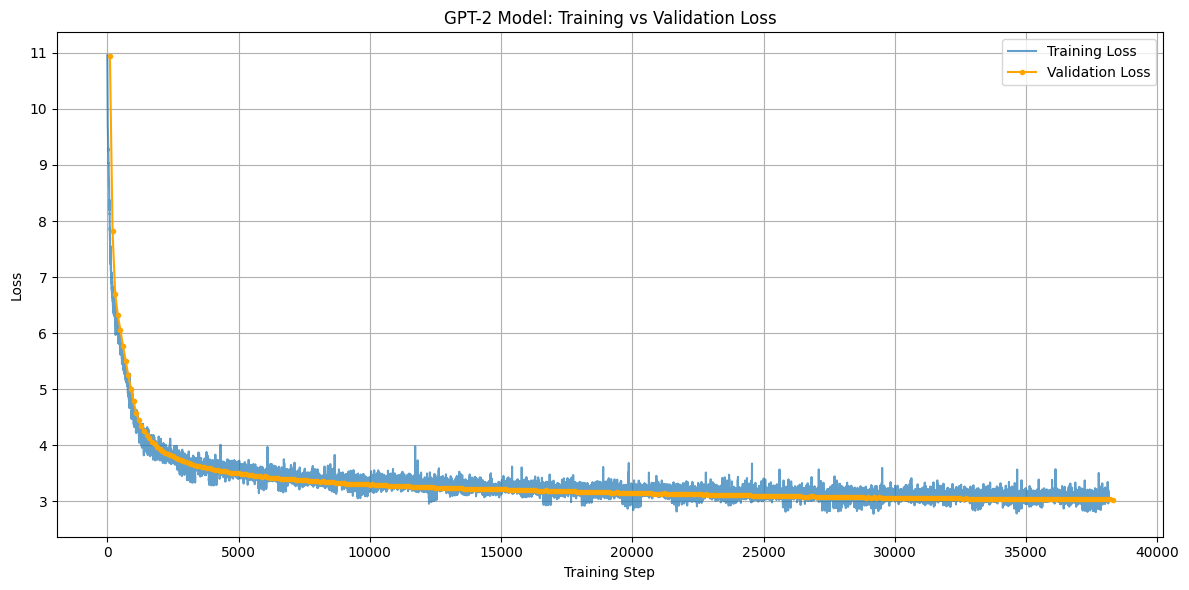

In [1]:
import os
import re
import matplotlib.pyplot as plt

# Pattern to match validation loss lines like: Validation loss: 7.8332
val_loss_pattern = re.compile(r"Validation loss: ([0-9]*\.?[0-9]+)")

# Initialize lists to store losses and steps
val_losses = []
val_steps = []
train_losses = []
train_steps = []

# Read and extract losses
file_path = r"10 - Let’s Reproduce GPT-2 (124M)\Training Run 03.txt"
with open(file_path, 'r', encoding='utf-8') as f:                    # Load training log from disk
    for line in f:
        # Match validation loss lines
        val_match = re.match(r"Validation loss: ([0-9.]+)", line)
        if val_match:
            val_losses.append(float(val_match.group(1)))
            val_steps.append(len(val_losses) * 100)                  # every 100 lines

        # Match training step + loss
        train_match = re.match(r"step (\d+) \|.*?loss: ([0-9.]+)", line)
        if train_match:
            train_steps.append(int(train_match.group(1)))
            train_losses.append(float(train_match.group(2)))

# Plot both training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_steps, train_losses, label="Training Loss", alpha=0.7)
plt.plot(val_steps, val_losses, label="Validation Loss", color="orange", marker=".")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("GPT-2 Model: Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Plot Norm and STD from main run

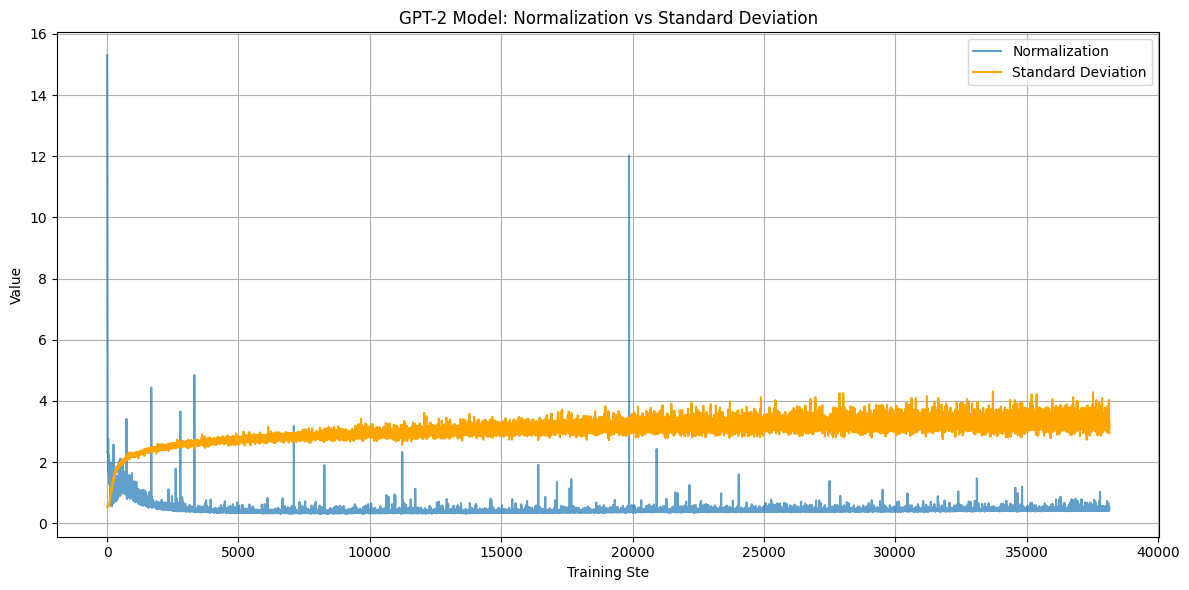

In [2]:
import os
import re
import matplotlib.pyplot as plt

# Initialize lists to store losses and steps
norm = []
norm_steps = []
std = []
std_steps = []

# Read and extract norm and std values
file_path = r"10 - Let’s Reproduce GPT-2 (124M)\Training Run 03.txt"
with open(file_path, 'r', encoding='utf-8') as f:                    # Load training log from disk
    for line in f:
        # Match norm
        norm_match = re.match(r"step (\d+) \|.*?norm: ([0-9.]+)", line)
        if norm_match:
            norm_steps.append(int(norm_match.group(1)))
            norm.append(float(norm_match.group(2)))
        # Match STD
        std_match = re.match(r"step (\d+) \|.*?std: ([0-9.]+)", line)
        if std_match:
            std_steps.append(int(std_match.group(1)))
            std.append(float(std_match.group(2)))

# Plot both Normalization and Standard Deviation values
plt.figure(figsize=(12, 6))
plt.plot(norm_steps, norm, label="Normalization", alpha=0.7)
plt.plot(std_steps, std, label="Standard Deviation", color="orange")
plt.xlabel("Training Ste")
plt.ylabel("Value")
plt.title("GPT-2 Model: Normalization vs Standard Deviation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Strategies for reducing overfitting
Validation Strategy Proposal for GPT-2 Training Using FineWeb-edu

#### Current Setup Recap
+ Model: GPT-2 (custom implementation following Karpathy)
+ Dataset: FineWeb-edu 10B token sample
+ Validation split: 1 shard out of 100 (1%)
+ Validation pattern: Scanned linearly with no shuffling
+ Observation: Training loss continues to fall; validation loss decreases initially, then steadily increases from ~step 3500 to step 16000.

#### Concerns Identified
+ Small validation set (1%) may be:
    + Too narrow to reflect generalization ability
    + Susceptible to variance or domain mismatch
    + Missing harder or more diverse examples
+ No corpus randomization may introduce positional bias and artifactually smooth overfitting

#### Proposed Adjustments
Option 1: Expand Validation Set Using Additional FineWeb-edu Shards
+ Identify additional FineWeb shards not included in the current 10B token sample.
+ Sample a fixed number of examples (e.g., 2% to 5% of total corpus) from different files.
+ Ensure domain and difficulty diversity (e.g., include harder educational material).
+ Pre-tokenize and cache if necessary.

Option 2: Stratify Validation Selection
+ Perform lightweight metadata classification or domain tagging of samples.
+ Use stratified sampling to create a validation set that matches the full corpus distribution.
+ May require one pass through the corpus but would give more reliable results.

Option 3: Rotate Validation Across Epochs
+ Instead of a fixed validation shard, rotate which shard is held out each epoch.
+ Compute running average of validation loss.
+ Benefit: exposes model to broader set of out-of-training samples.

Option 4: Hybrid: Keep Static + Floating Validation Sets
+ Maintain original shard as static benchmark.
+ Add rotating or diversified secondary validation set to compare trends.
+ Track both sets during training and compare convergence behavior.

#### Tooling Enhancements
+ Track validation loss with higher frequency (e.g., every 200 steps) to catch sharper inflections.
+ Store per-validation checkpoint metrics to assess per-shard behavior.

#### Next Steps
1. Identify and acquire additional FineWeb-edu shards.
2. Analyze overlap (if any) with training shards to ensure clean separation.
3. Implement at least one of the proposed strategies and replot training vs. validation.

#### Goal
Make validation loss a more meaningful diagnostic of generalization, and ensure training signals guide architecture/tuning decisions effectively.

## Investigate normalization spike by decoding suspect data

+ Assumes shards ~100M tokens and filenames with "train" in them (match your earlier edufineweb_train_00064.npy naming).
+ Memory-maps shards to avoid loading 100M+ tokens for everything.
+ Decodes the entire optimizer-step worth of tokens. If that’s huge for printing, it truncates to a readable slice.
+ If the token range crosses a shard boundary, the script concatenates parts from the next shards.

##### Assumptions
+ `B` = 8 (micro-batch size)
+ `T` = 1024 (context length)
+ `grad_accum_steps` = 32 (gradient accumulation microbatches per optimizer step) — you gave this earlier
+ `step_of_spike` = 19867
+ `each shard` ≈ shard_size = 100,000,000 tokens (FineWeb-edu sample shards)
+ shards are stored as `.npy` files (e.g. `edufineweb_train_000018.npy`) and were tokenized with GPT-2 tokenizer.

Candidate file containing spike
```
data_root = "FineWeb-edu"                                         # Directory containing FeneWeb data
shard = "edufineweb_train_000018.npy"                             # Suspect shard
data = os.path.join(data_root, shard)                             # Joined filepath and name
```
#### Quick checks to run once you have the decoded excerpt
Look for:
+ Very long code blocks (starts with def , lots of braces/semicolons) or long base64/hex blobs,
+ HTML or scraped pages (<html>, lots of tags),
+ Repeated punctuation sequences like !!!!!!!!! or ?!!?!,
+ Non-text binary garbage (decoding may show many invalid characters),
+ Huge monolithic numeric tables or very long token runs without EOT (<|endoftext|> token),
+ Extremely long single “word” (very long token sequences created by no whitespace) — can spike gradients.

If you find one of the above, that almost certainly explains the one-off gradient surge.

In [3]:
# spike_inspect.py
import os
import math
import numpy as np
import tiktoken                         # pip install tiktoken if needed
from pathlib import Path

# ---------- USER CONFIG ----------
data_dir = "FineWeb-edu"                # folder with edufineweb_train_000XX.npy
B = 8
T = 1024
grad_accum_steps = 32
step_of_spike = 19867                   # change if needed
shard_size = 100_000_000                # tokens per shard (approx)
token_dtype = np.uint16                 # or np.int32 depending on how saved
context_window = 1024                   # how many tokens to show around the start
# ----------------------------------

tokens_per_microbatch = B * T
tokens_per_step = tokens_per_microbatch * grad_accum_steps

global_token_start = step_of_spike * tokens_per_step                   # start token index for that optimizer step
global_token_end   = global_token_start + tokens_per_step

print(f"Tokens per microbatch: {tokens_per_microbatch}")
print(f"Tokens per optimizer step: {tokens_per_step:,}")
print(f"Global token range for step {step_of_spike}: {global_token_start:,} .. {global_token_end:,}")

# determine shard index (0-based)
# shard_index = global_token_start // shard_size                        #### THIS IS NOT RIGHT IF DATA IS SHUFFLED!
shard_index = 17                                                        # use 17 to index shard 18 where spike occured
shard_offset = global_token_start % shard_size

print(f"Estimated shard index (0-based): {shard_index}")
print(f"Estimated offset inside shard: {shard_offset:,}")

# find matching shard file (training split)
shard_files = sorted([p for p in Path(data_dir).glob("*train*.npy")])
if len(shard_files) == 0:
    raise FileNotFoundError("No train .npy shards found in data_dir")
if shard_index >= len(shard_files):
    raise IndexError(f"Shard index {shard_index} >= available shards {len(shard_files)}")

shard_file = shard_files[shard_index]
print("Using shard file:", shard_file)

# load just the portion we need (load whole shard if small; else slice)
tokens = np.load(shard_file, mmap_mode='r')                            # memory-map to avoid loading whole file
# ensure dtype consistent
tokens = tokens.astype(np.int64, copy=False)
print ("tokens length:", len(tokens))

# get local slice: attempt to load tokens_per_step tokens starting at shard_offset
length_needed = tokens_per_step

available_in_shard = len(tokens) - shard_offset
print ("available_in_shard:", available_in_shard)

print("shard offset:", shard_offset)

if available_in_shard < length_needed:
    print(f"Note: requested range spans shard boundary (available in this shard: {available_in_shard}).")
    # we will load available_in_shard from this shard and rest from next shard(s)
    local_part = tokens[shard_offset : ]
    remaining = length_needed - available_in_shard
    # load from subsequent shards
    rest = []
    next_idx = shard_index + 1
    while remaining > 0 and next_idx < len(shard_files):
        t2 = np.load(shard_files[next_idx], mmap_mode='r').astype(np.int64, copy=False)
        take = min(len(t2), remaining)
        rest.append(t2[:take])
        remaining -= take
        next_idx += 1
    token_seq = np.concatenate([local_part] + rest)
else:
    token_seq = tokens[shard_offset : shard_offset + length_needed]

print("available in shard:", available_in_shard)
print("length_needed:", length_needed)
print("Loaded token sequence length:", len(token_seq))

# decode with tiktoken (GPT-2)
enc = tiktoken.get_encoding("gpt2")   # if you used a different encoding, change here

# choose a smaller region to print for human readability (Default show_start will print from start of shard
# Testing shows ALL shars are 262143 tokens long
#show_start= 0                                        # Default                                        
#show_start = 262143                                  ### <- Location of final token in section (onumber of tokens in ptimizer step)
show_start = 0                                        ### <- change this offset to print a different part ofthe section

show_len = min( max(262144, context_window), len(token_seq))  # show at least context_window but cap    # changed from 2048 !!! Show ALL
print ("show_len", show_len)
decoded = enc.decode(token_seq[show_start: show_start + show_len].tolist())
print ("Decoded show start", show_start)
print ("Decoded show len", show_len)
print ("Decoded show start + show_len", show_start + show_len)

print("\n--- Decoded excerpt ---\n")
print(decoded[:2000])   # print first 4k chars (adjust as desired)

# Also print some diagnostics to detect weird content:
def simple_stats(tokarr):
    toks = tokarr.tolist()
    uniques = len(set(toks))
    avg_token = sum(toks)/len(toks)
    max_run_punct = 0
    # crude check: detect long sequences of punctuation-like tokens by decoding small chunks
    s = enc.decode(toks[:200]).lower()
    return {
        "n_tokens": len(toks),
        "n_uniques": uniques,
        "avg_token_id": avg_token,
    }

print("\n--- Simple token stats ---")
print(simple_stats(token_seq[:min(1000, len(token_seq))]))

# Optionally, write the decoded chunk to a file for further inspection
outpath = Path("spike_inspect_output.txt")
outpath.write_text(decoded, encoding="utf-8")                     # Force UTF-8 when writing
print("\nDecoded excerpt also saved to:", outpath)

Tokens per microbatch: 8192
Tokens per optimizer step: 262,144
Global token range for step 19867: 5,208,014,848 .. 5,208,276,992
Estimated shard index (0-based): 17
Estimated offset inside shard: 8,014,848
Using shard file: FineWeb-edu\edufineweb_train_000018.npy
tokens length: 100000000
available_in_shard: 91985152
shard offset: 8014848
available in shard: 91985152
length_needed: 262144
Loaded token sequence length: 262144
show_len 262144
Decoded show start 0
Decoded show len 262144
Decoded show start + show_len 262144

--- Decoded excerpt ---

 are designated with their own dedicated hardware to wall each other off and only allow credentialed users to access the system. Rules are built into network configurations to determine how users, services and devices on subnetworks can interconnect with each other.
Types of network segmentation
There are two types of network segmentation: physical and virtual.
Physical segmentation uses dedicated hardware to build segments. While physical segm

### Exploration of results
Text is output that looks normal for the most part but there are many lines with unusual newline formatting (short lines mid-sentence). Oddly placed newlines. If they break semantic units mid-sentence, the model may struggle to predict the next token because the distribution is suddenly much more random. This can create large loss spikes, which translate into larger gradient norms.

Batches wither side of the likely problem batch contain English-Chinese translation samples and long lists of URLS. These can also be problematic:

##### Bilingual text
+ Switching between language scripts (Latin → Chinese) in the middle of a training context forces the model to activate completely different parts of its embedding space.
+ If it hasn’t seen much bilingual parallel text before, this can cause sudden large updates.

##### Long URL sequences
+ URLs are often tokenized into long runs of “rare” subwords or character-level chunks.
+ Rare tokens → large embedding gradients when the model tries to memorize them.

### Test the model with longer prompts

In [6]:
# Load mmodel
import os
import math
import torch
import tiktoken
from torch.nn import functional as F

# Autodetect available devices to automatically run on the device with highest capability.
# Ideally run on a GPU with CUDA support if one is available
device = "cpu"                                                     # By default select cpu which is always available
if torch.cuda.is_available():
    device = "cuda"                                                # Switch to best option cuda if it exists
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"                                                 # Try mps if cuda not available (mps is on decent Apple macbooks)
print(f"Using device: {device}", "\n")
#device = "cpu"                                                    # OVERRIDE to run on CPU by uncommenting

# Create model
model = GPT(GPTConfig(vocab_size=50304))                           # Use large vocab size that is nice multiple of 2 so runs fast
model.to(device)

# Load checkpoint
checkpoint = torch.load("10 - Let’s Reproduce GPT-2 (124M)/Training Run 03 - Chckpoints/gpt2_checkpoint_full_step_38000.pt")
#checkpoint = torch.load("10 - Let’s Reproduce GPT-2 (124M)/Training Run 03 - Chckpoints/gpt2_checkpoint_full_step_38145-final.pt")
model.load_state_dict(checkpoint['model_state_dict'])

Using device: cuda 

Weight tying

Initialize weights with standard deviation 0.02



C:\Users\johns\AppData\Local\Temp\ipykernel_24148\3525947028.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("10 - Let’s Reproduce GPT-2 (124M)/

<All keys matched successfully>

In [8]:


num_return_sequences = 4
max_length = 500
#tokens = enc.encode("I read the news today, oh, boy. About a lucky man who made the grade.")                       # Starter prompt
tokens = enc.encode("I know the answer to that question. Let me explain how we know dinosaurs had feathers.")  
tokens = torch.tensor(tokens, dtype=torch.long)          # Covert to tensors
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1) 
xgen = tokens.to(device)

sample_rng = torch.Generator(device=device)              # Random number generator
sample_rng.manual_seed(42)   
while xgen.size(1) < max_length:
    # Forward the model to get the logits
    with torch.no_grad():                                # no_grad means don't call backpropagation so less processing
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            logits, loss = model(xgen)                   # (B, T, vocab_size)
        logits = logits[:, -1, :]                        # (B, vocab_size) - logits at the last position
        probs = F.softmax(logits, dim=-1)                # Get the probabilities
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1) # top-k sampling of 50 - topk_probs/indices become (5, 50)
        ix = torch.multinomial(topk_probs,1)             # (B, 1) - Select a token from the top-k probabilities
        xcol = torch.gather(topk_indices, -1, ix)        # (B, 1) - Gather corresponding indices
        xgen = torch.cat((xgen, xcol), dim=1)            # Append the sequence

# Print the generated text
for i in range(num_return_sequences):
    tokens = xgen[i, :max_length].tolist()               # Get the tokens from all of the 5 samples 
    decoded = enc.decode(tokens)                         # Use tiktoken's decoder to convert tokens back to characters
    print(i, ">", decoded)

0 > I know the answer to that question. Let me explain how we know dinosaurs had feathers. Our feathered friends have. (For a fun Science experiment) Let’s see what we can find.
Some of the best bird feathers we’ve seen are feathers from the T-rex from the tyrannosaurus Rex. It’s very rare to find a T-rex with feathers. It took the dinosaur a whole day to see and I can’t tell you if they were birds.
That’s just a tip of the hat. It’s a new and wonderful thing.
One of our friends is called an angel. He usually takes pictures, sends some to us via email and sends you photos on his Facebook page. The picture is really cool.
One of our students came down to me from his day job. She got a huge lump, and, as I said, she saw it in her photo-editing book.
We were so happy when these fossils were discovered in Oregon. I guess it’s because they are a kind of symbol for the world of dinosaurs. Let’s go back and look at them now.
We have many fossils from dinosaurs that are so well-known even to t

## Evaluation of the model's performance

#### Syntactic fluency
+ GPT-2 has enough capacity to model grammar and sentence structure well.
+ That’s why individual sentences sound “correct” and flow naturally.
+ Even transitions between ideas make grammatical sense.

+ #### Local semantic consistency
+ In short spans (20–50 tokens) the model keeps to the topic — here, feathers and paleontology — because the attention mechanism still has a clear representation of the initial prompt.
+ It’s strong at continuing the current thought for a while.

#### Coherence breakdown over long stretches:
+ GPT-2’s small context window (1,024 tokens in the base config) means it “forgets” the initial intent quickly.
+ This is why it drifts into unrelated topics (plastic straws!) after the <|endoftext|> marker — it treats that token as “end of document” and happily starts a new document continuation, unrelated to the original dinosaur explanation.

#### Repetitions and slight nonsense
+ A smaller model’s internal representations don’t compress long-term world knowledge as well as GPT-3 or later.
+ It often “loops” concepts (“two wings… third… still intact”) because it’s following statistical grooves from the training data rather than maintaining a factually coherent scene.

#### How this compares to expectations:
+ Loss ≈ 3.0 is actually reasonable for GPT-2-scale training from scratch, even on 10 B tokens. Andrej Karpathy’s nanoGPT runs hit similar ranges.
+ The output produced here had solid short-form coherence, good syntax, plausible vocabulary, and topic drift + hallucination on longer runs.
+ To push past that requires one or more of the following:
    + Increase model size (more parameters to capture richer semantics)
    + Extending context length (better long-term coherence)
    + Finetuning specifically on your target domain (to anchor the knowledge)
